In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.integrate import solve_ivp
def jitter(U, S, scale=0.1):
    S = S + np.random.normal(loc=0.0, scale=scale, size=np.size(S))
    U = U + np.random.normal(loc=0.0, scale=scale, size=np.size(U))
    S1 = S[(S>0)&(U>0)]
    U1 = U[(S>0)&(U>0)]
    return U1, S1

def _simulate(u0, s0, alpha, beta, gamma, t, samples):
    def trans_dynamics(t, expr): 
        s = expr[0]
        u = expr[1]
        du_dt = alpha - beta*u
        ds_dt = beta*u - gamma*s
        return [ds_dt, du_dt]
    t_space = np.linspace(0, t, samples)
    #available methods: 'RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA'
    num_sol = solve_ivp(trans_dynamics, [0, t], [s0, u0], method='RK45', dense_output=True)
    XY_num_sol = num_sol.sol(t_space)
    S, U = XY_num_sol[0], XY_num_sol[1]
    return U, S

def forward_simulate(alpha, beta, gamma, t, samples):
    '''forward start from (0, 0)'''
    return _simulate(0, 0, alpha, beta, gamma, t, samples)

def backward_simulate(u0, s0, beta, gamma, t, samples):
    #u0, s0 = alpha/beta, alpha/gamma
    return _simulate(u0, s0, 0, beta, gamma, t, samples)

def full_simulate(alpha, beta, gamma, t1, t2, samples1, samples2):
    U1, S1 = forward_simulate(alpha, beta, gamma, t1, samples1)
    U2, S2 = backward_simulate(np.max(U1), np.max(S1), beta, gamma, t2, samples2)
    return np.append(U1, U2), np.append(S1, S2)

class forwardModule(nn.Module):
    def __init__(self, alpha, beta, gamma):
        super(forwardModule, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha))
        self.beta = nn.Parameter(torch.tensor(beta))
        self.gamma = nn.Parameter(torch.tensor(gamma))
    def forward(self, u0, s0, dt):
        return u0 + (self.alpha - self.beta*u0)*dt, s0 + (self.beta*u0 - self.gamma*s0)*dt

class fullModule(nn.Module):
    def __init__(self, alpha, beta, gamma):
        super(fullModule, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha))
        self.beta = nn.Parameter(torch.tensor(beta))
        self.gamma = nn.Parameter(torch.tensor(gamma))
    def forward(self, u0, s0, dt):
        '''if u/s < gamma/beta, then alpha is zero
        '''
        region = u0-self.gamma/self.beta*s0
        sig = nn.Sigmoid()
        u1 = u0 + (sig(region*10)*self.alpha - self.beta*u0)*dt
        s1 = s0 + (self.beta*u0 - self.gamma*s0)*dt
        return u1, s1

def init_parameters(u0, s0, cut=0.99):         
    un = np.quantile(u0, cut)
    sn = np.quantile(s0, cut)
    alpha = np.float32(un*sn)
    beta = np.float32(sn)
    gamma = np.float32(un)
    return alpha, beta, gamma

def cost_fn(u0, s0, u1, s1, indices, direct=None):
    """Cost function
    Args:
        direct: 1: positive; -1: negative
    Return:
        list of cosine distance
    """
    # Velocity from (u0, s0) to (u1, s1)
    uv, sv = u1-u0, s1-s0 
    # Velocity from (u0, s0) to its neighbors
    unv, snv = u0[indices.T[1:]] - u0, s0[indices.T[1:]] - s0 
    # Sigmoid
    sig = nn.Sigmoid()
    den = torch.sqrt(unv**2 + snv**2) * torch.sqrt(uv**2+sv**2)
    den[den==0] = -1 # den==0 will cause nan in training 
    cosine = torch.where(den!=-1, (unv*uv + snv*sv) / den, torch.tensor(1.))
    cosine_max = torch.max(cosine, 0)[0]
    if direct is not None:
        #when direct not None, cost multiple a penalty to make it all point to the same direction
        if direct == 1:
            cosine_max = sig((uv+sv)/(max(uv+sv)-min(uv+sv))*100)*cosine_max
        elif direct == -1:
            cosine_max = sig(-(uv+sv)/(max(uv+sv)-min(uv+sv))*100)*cosine_max
    return 1 - cosine_max   

def init_module(device="cpu", mode="forward", alpha=1.0, beta=2.0, gamma=2.0):
    """Module initiation
    Args:
        direct: 1: positive; -1: negative
    """
    if mode=="forward":
        testm = forwardModule(alpha, beta, gamma).to(device)
    elif mode=="full":
        testm = fullModule(alpha, beta, gamma).to(device)
    return testm

def run_module(
    module, 
    optimizer, 
    u0, s0, 
    barcode=None, 
    n_neighbors=30, 
    direct=None, 
    cut=None, 
    dt=0.001, 
    times=10000, 
    rept_freq=100, 
    rprint=False
):
    """Run module
    Args:
        direct: 1: positive; -1: negative
        times: training times
        rept_freq: report freqency
    """
    u0, s0 = u0.astype(np.float32), s0.astype(np.float32)
    u0, s0 = np.array(u0), np.array(s0)
    #generate neighbour indeces and expr dataframe
    points = np.array([s0, u0]).transpose()
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(points)
    distances, indices = nbrs.kneighbors(points)
    expr = pd.merge(pd.DataFrame(s0, columns=['s0']), pd.DataFrame(u0, columns=['u0']), left_index=True, right_index=True)
    if barcode is not None:
        expr.index = barcode
    testm = module
    # Run the model and save results
    result = expr
    result_index = result.index
    result2 = None
    u0 = torch.tensor(expr['u0'])
    s0 = torch.tensor(expr['s0'])
    indices = torch.tensor(indices)
    for i in range (times):
        u1, s1 = testm(u0, s0, dt)
        cost = cost_fn(u0, s0, u1, s1, indices, direct=direct)
        if cut is None:
            cost_counted = cost
        else:
            cost_counted = cost[s0<torch.quantile(s0, cut)]
        cost_mean = torch.mean(cost_counted)
        if i%rept_freq == 0:
            if rprint:
                print("Iteration:", i, " ,cost:", cost_mean.data.numpy(), " ,alpha:", testm.alpha.data.numpy(), " ,beta:", testm.beta.data.numpy(), " ,gamma:", testm.gamma.data.numpy())
            tmp = pd.DataFrame(s1.data.numpy())
            tmp = tmp.merge(pd.DataFrame(u1.data.numpy()), left_index=True, right_index=True)
            tmp.columns = ['s1', 'u1']
            tmp['iteration'] = i
            tmp['cost'] = cost.data.numpy()
            tmp['alpha'] = testm.alpha.data.numpy()
            tmp['beta'] = testm.beta.data.numpy()
            tmp['gamma'] = testm.gamma.data.numpy()
            tmp['cost_mean'] = cost_mean.data.numpy()
            tmp['dt'] = dt
            tmp.index = result_index
            result2 = result2.append(tmp) if result2 is not None else tmp
        testm.zero_grad()
        cost_mean.backward()
        optimizer.step()
        testm.alpha.data = testm.alpha.data.clamp(0,np.infty)
        testm.beta.data = testm.beta.data.clamp(0,np.infty)
        testm.gamma.data = testm.gamma.data.clamp(0,np.infty)
    result = result.merge(result2, left_index=True, right_index=True)
    return result

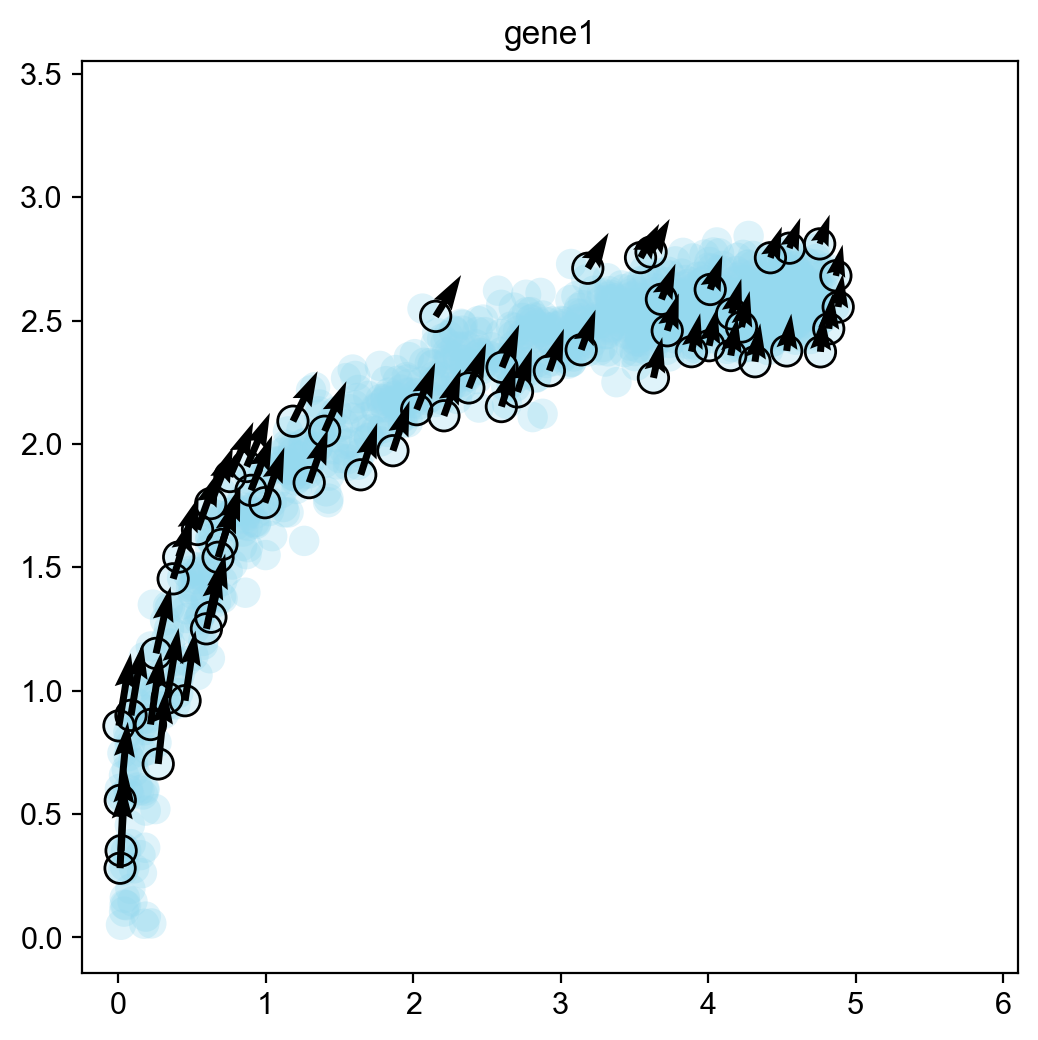

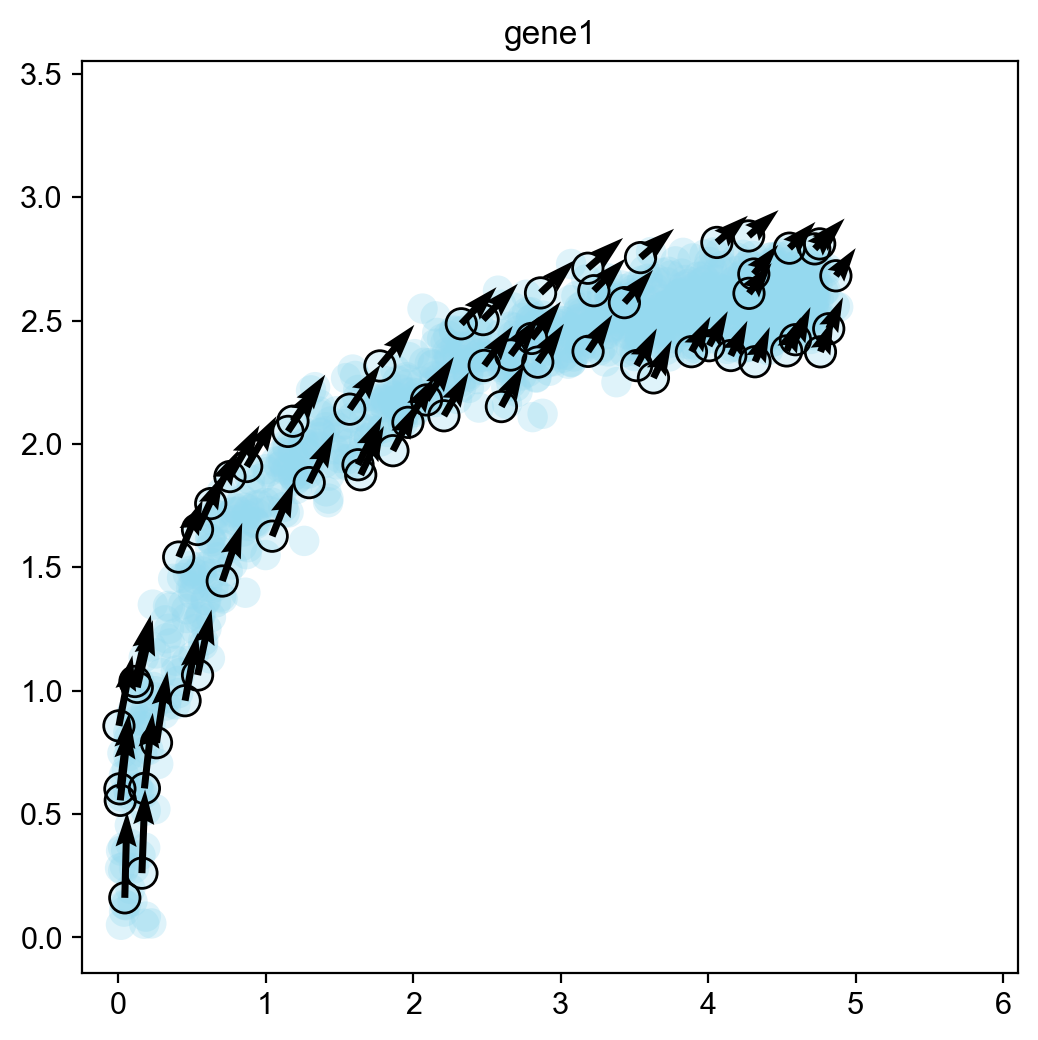

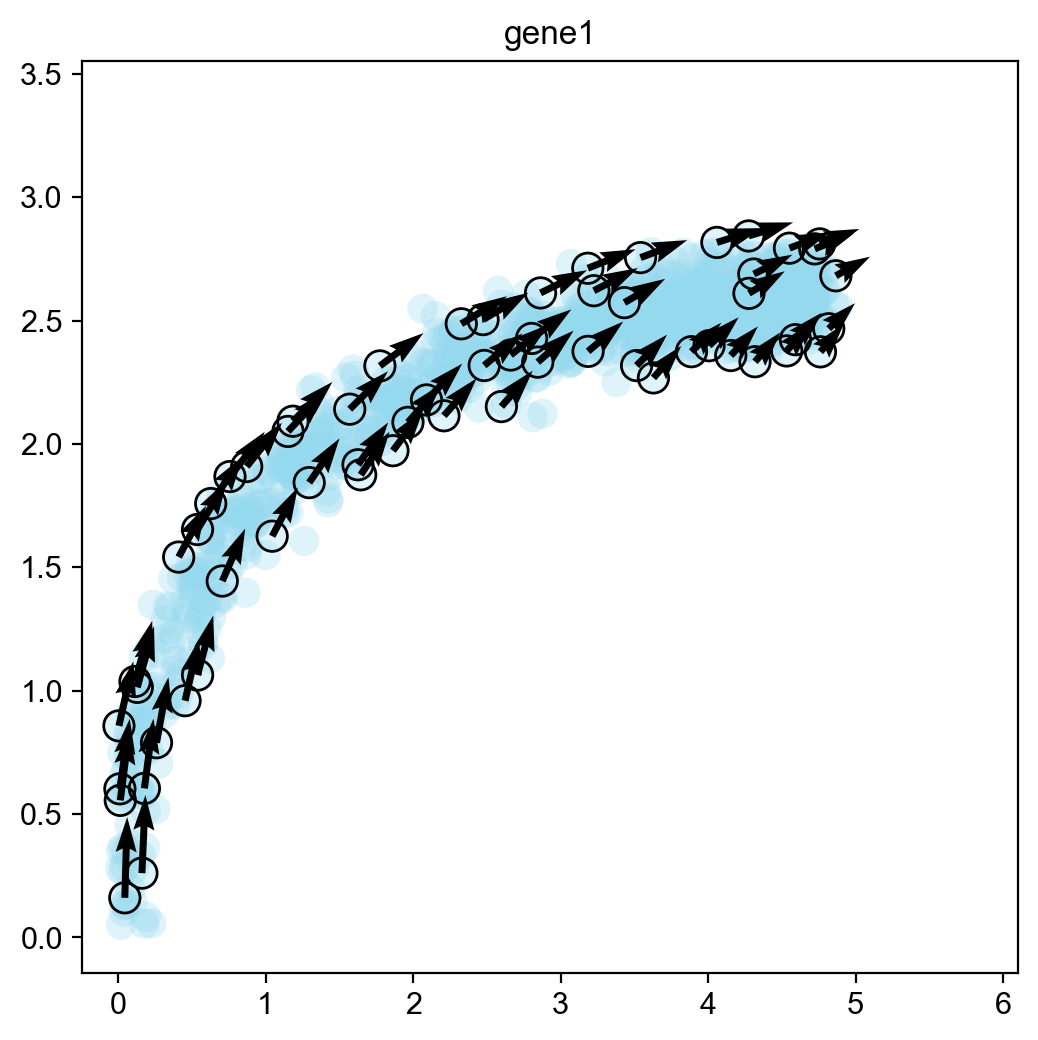

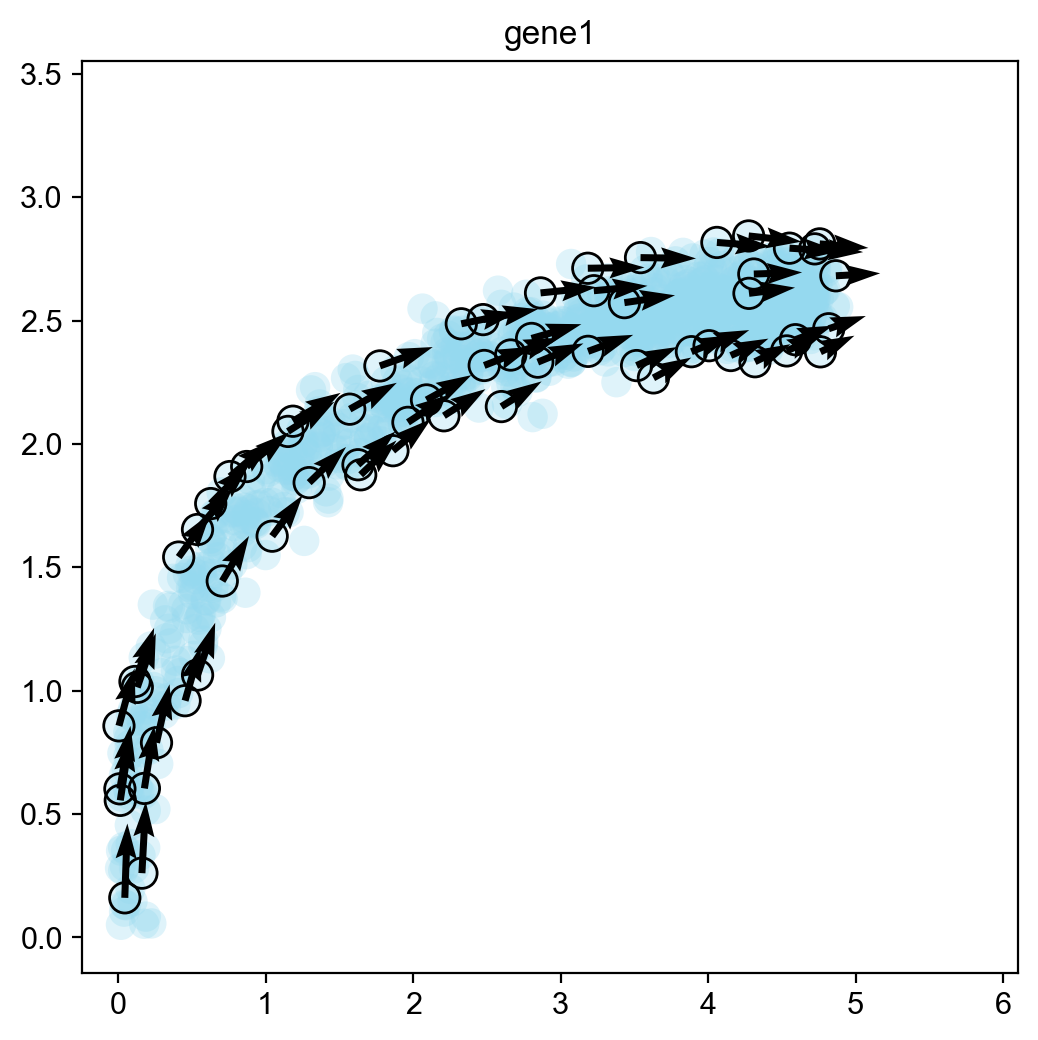

In [2]:
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
import random
sys.path.append('.')
from utilities import set_rcParams
set_rcParams()
#########################
# forward 

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
# ===================
# Use simulation data
# -  

u0, s0 = forward_simulate(5.2, 2.0, 1.0, 3, 1000)
u0, s0 = jitter(u0, s0 )
# ==================
# Run model
# -

alpha=8.0
beta=2.0
gamma=0.9
m = init_module(mode="forward", alpha=alpha, beta=beta, gamma=gamma) #forward or full
optimizer = optim.SGD(m.parameters(), lr=0.1, momentum=0.8)
result = run_module(module=m, optimizer=optimizer, u0=u0, s0=s0, direct=None, cut=0.9, times=201, rept_freq=10)
# =============================
# Show results of pytorch
# -

result['gene_name'] = "gene1"
from velocity_plot import velocity_plot as vpl
result_iter0 = result[result['iteration']==0]
vpl.velocity_gene('gene1',result_iter0,save_path=None)
result_iter20 = result[result['iteration']==20]
vpl.velocity_gene('gene1',result_iter20,save_path=None)
result_iter50 = result[result['iteration']==50]
vpl.velocity_gene('gene1',result_iter50,save_path=None)
result_iter200 = result[result['iteration']==200]
vpl.velocity_gene('gene1',result_iter200,save_path=None)

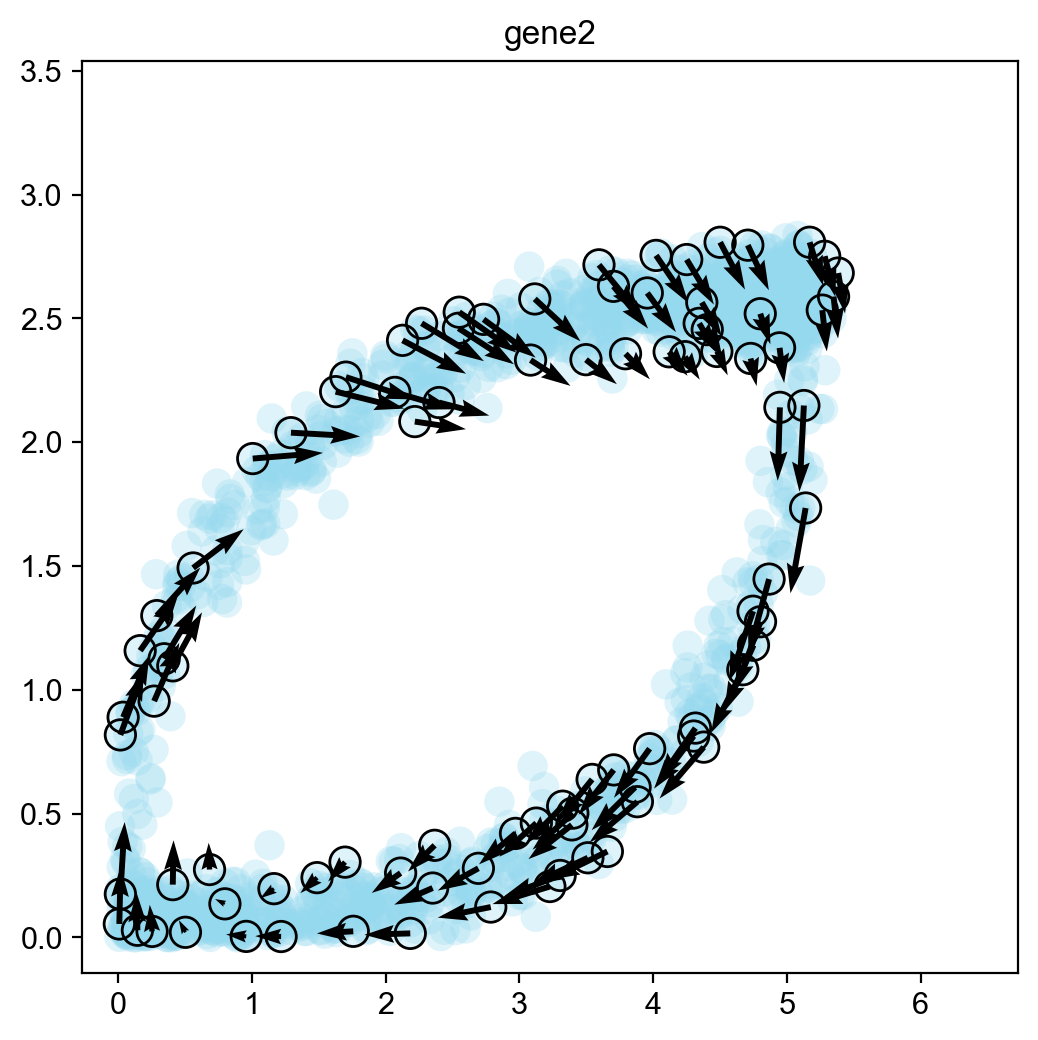

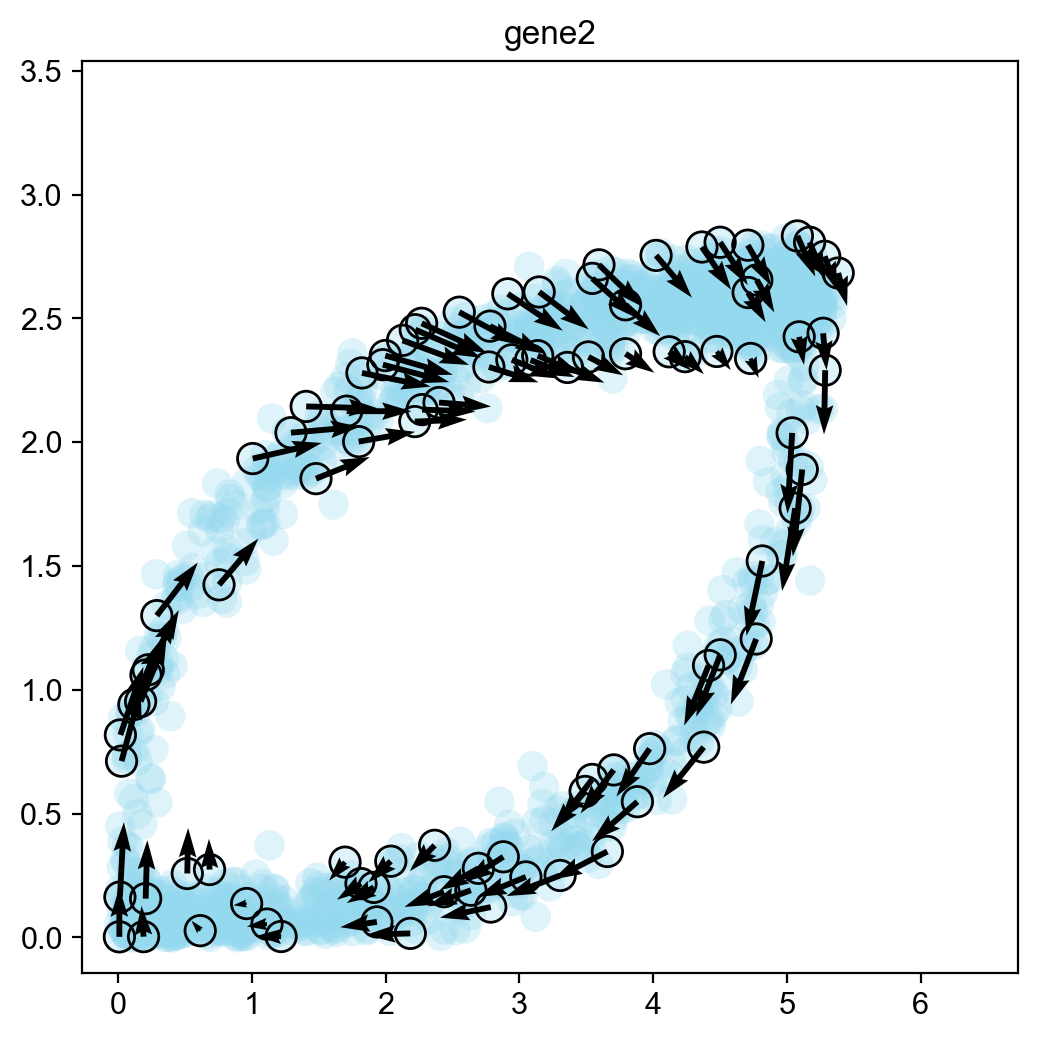

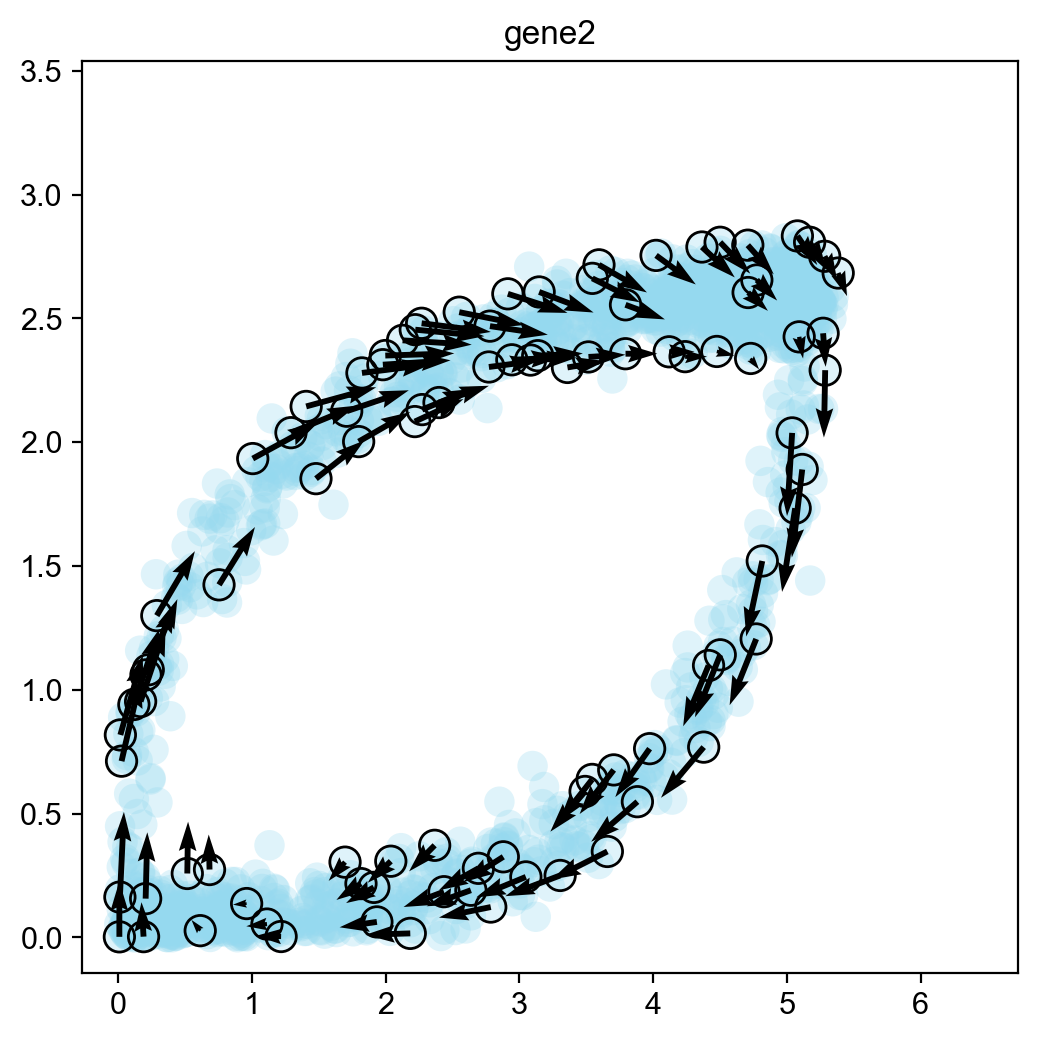

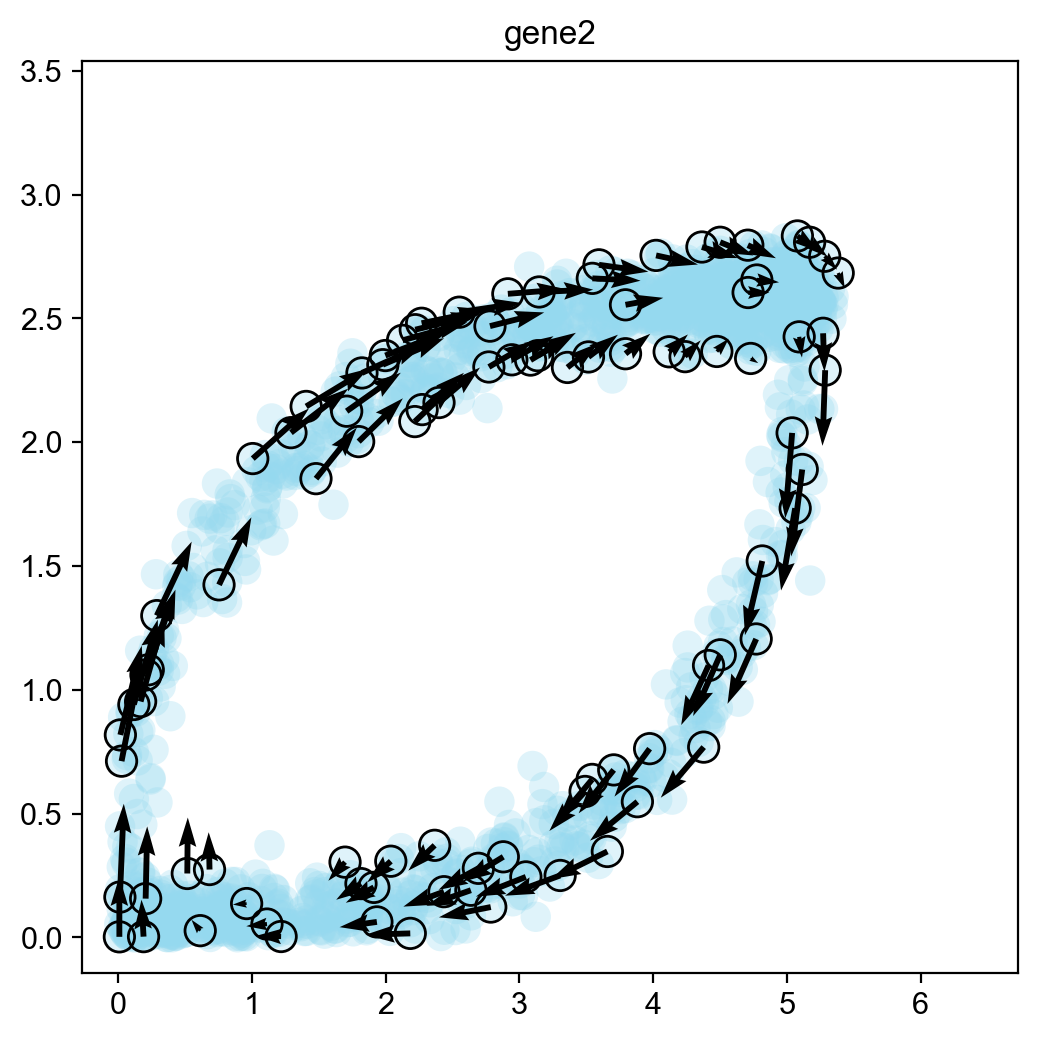

In [3]:
import torch.optim as optim
import matplotlib.pyplot as plt
import sys
import random
sys.path.append('.')
from utilities import set_rcParams
set_rcParams()
#########################
# full 

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
# =============================
# Use simulation data
# -  

u0, s0 = full_simulate(5.2, 2.0, 1.0, 5, 5, 1000, 1000)
u0, s0 = jitter(u0, s0 )
# =============================
# Run nn model of pytorch step by step
# -
#alpha, beta, gamma = init_parameters(u0, s0)

alpha=4.0
beta=2.0
gamma=0.9
m = init_module(mode="full", alpha=alpha, beta=beta, gamma=gamma) #forward or full
optimizer = optim.SGD(m.parameters(), lr=0.1, momentum=0.8)
result = run_module(module=m, optimizer=optimizer, u0=u0, s0=s0, direct=None, times=201, rept_freq=10)
# =============================
# Show results of pytorch
# -

result['gene_name'] = "gene2"
from velocity_plot import velocity_plot as vpl
result_iter0 = result[result['iteration']==0]
vpl.velocity_gene('gene2',result_iter0,save_path=None)
result_iter20 = result[result['iteration']==20]
vpl.velocity_gene('gene2',result_iter20,save_path=None)
result_iter50 = result[result['iteration']==50]
vpl.velocity_gene('gene2',result_iter50,save_path=None)
result_iter200 = result[result['iteration']==200]
vpl.velocity_gene('gene2',result_iter200,save_path=None)